Initial shape: (303, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  

NaNs per column after cleaning:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Any NaNs in X_train_scaled? False
Any NaNs in X_test_scaled? False

Tuning RBF SVM...
Fitting 3 folds for each of

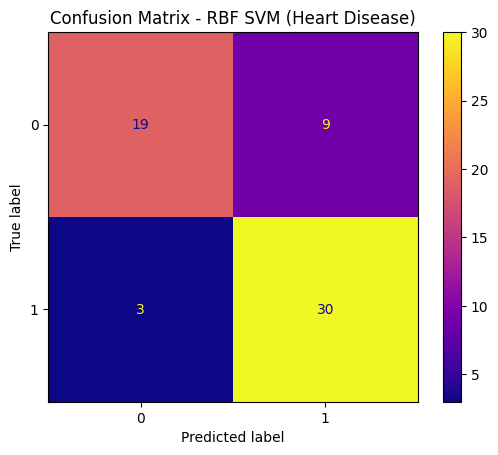

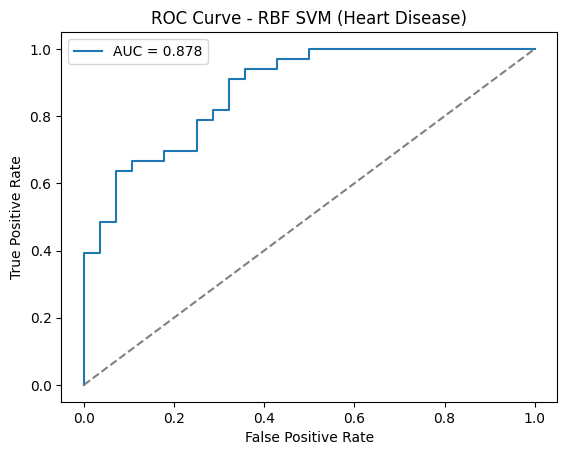

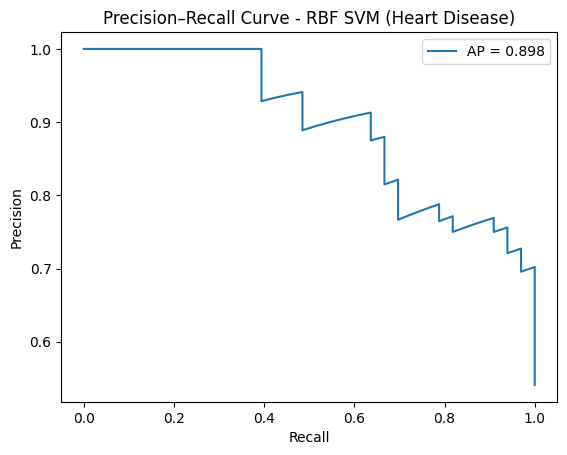

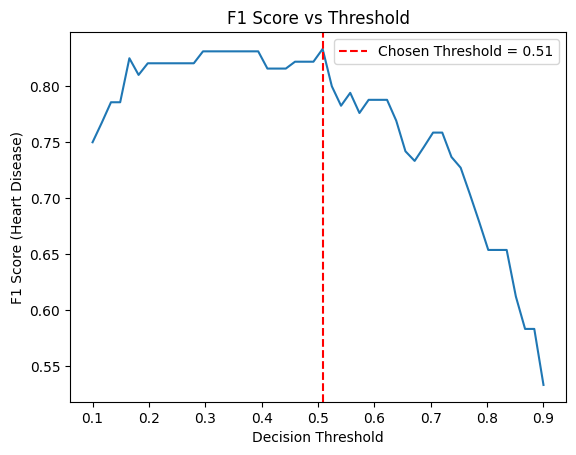

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)
from scipy.stats import loguniform
import matplotlib.pyplot as plt

# 1. Data Collection
df = pd.read_csv("heart.csv")

print("Initial shape:", df.shape)
print(df.head())

# 2. Basic Preprocessing and Target Identification
target_col = "target"
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.fillna(df.mean(numeric_only=True))

print("\nNaNs per column after cleaning:")
print(df.isna().sum())

X = df.drop(target_col, axis=1)
y = df[target_col]

# 3. Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAny NaNs in X_train_scaled?", np.isnan(X_train_scaled).any())
print("Any NaNs in X_test_scaled?", np.isnan(X_test_scaled).any())

# 5. Base SVM Model (RBF Kernel)
base_svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=True,
    random_state=42
)

# 6. Hyperparameter Tuning with Randomized Search
param_dist = {
    "C": loguniform(1e-2, 1e2),
    "gamma": loguniform(1e-4, 1e1)
}

random_search = RandomizedSearchCV(
    estimator=base_svm,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score="raise"
)

print("\nTuning RBF SVM...")
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters:", random_search.best_params_)

best_svm = random_search.best_estimator_

# 7. Probability Calibration
calibrated_svm = CalibratedClassifierCV(best_svm, method="sigmoid", cv=3)

calibrated_svm.fit(X_train_scaled, y_train)

# 8. Decision Threshold Optimization
y_probs = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds:
    y_temp = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_temp))

best_index = int(np.argmax(f1_scores))
best_threshold = thresholds[best_index]
print(f"\nBest threshold (by F1): {best_threshold:.3f}")
print(f"Best F1 at this threshold: {f1_scores[best_index]:.4f}")

# Final predictions with chosen threshold
y_pred = (y_probs >= best_threshold).astype(int)

# 9. Evaluation
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Accuracy ---")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n--- F1 Score (Heart Disease Class) ---")
print(f"{f1_score(y_test, y_pred):.4f}")

# 10. Visualizations

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="plasma")
plt.title("Confusion Matrix - RBF SVM (Heart Disease)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RBF SVM (Heart Disease)")
plt.legend()
plt.show()

# Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - RBF SVM (Heart Disease)")
plt.legend()
plt.show()

# F1 Score vs Threshold
plt.figure()
plt.plot(thresholds, f1_scores)
plt.axvline(x=best_threshold, linestyle="--", color="red",
            label=f"Chosen Threshold = {best_threshold:.2f}")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score (Heart Disease)")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.show()
